# Generalized Lotka Volterra

We consider a Generalized Lotka Volterra system with $3$ populations
$$
\frac{\partial}{\partial t}u_i(t) = r_iu_i(t) - \sum_{j\neq i}\alpha_{ij}u_j(t)
-\alpha_{i,i}u_i(t) + c_iu_i(t) + \sum_{j \neq i} c_ju_j(t), i\in\{1, 2, 3\}
$$

More information on this ODE system can be found at [https://stefanoallesina.github.io/Sao_Paulo_School/intro.html#basic-formulation](https://stefanoallesina.github.io/Sao_Paulo_School/intro.html#basic-formulation)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable

Import our package

In [3]:
import jinns

Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx

import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)

Create the neural network architecture for the PINN with `equinox`. Note that we will use the same architecture for the 3 populations.

In [5]:
eqx_list = [
    [eqx.nn.Linear, 1, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 1],
    [jnp.exp]
]
key, subkey = random.split(key)
u = jinns.utils.create_PINN(subkey, eqx_list, "ODE")

In [6]:
init_nn_params = u.init_params()

Create a DataGenerator object

In [7]:
n = 320
batch_size = 32
method = 'uniform'
tmin = 0
tmax = 1

Tmax = 30
key, subkey = random.split(key)
train_data = jinns.data.DataGeneratorODE(
    subkey,
    n,
    tmin,
    tmax,
    batch_size,                    
    method=method
)

Initialize 3 set of neural network parameters for the 3 populations

In [8]:
init_nn_params_list = []
for _ in range(3):
    key, subkey = random.split(key)
    u = jinns.utils.create_PINN(subkey, eqx_list, "ODE", 0)
    init_nn_params = u.init_params()
    init_nn_params_list.append(init_nn_params)

Visualize the output of the neural networks before the parameter learning step

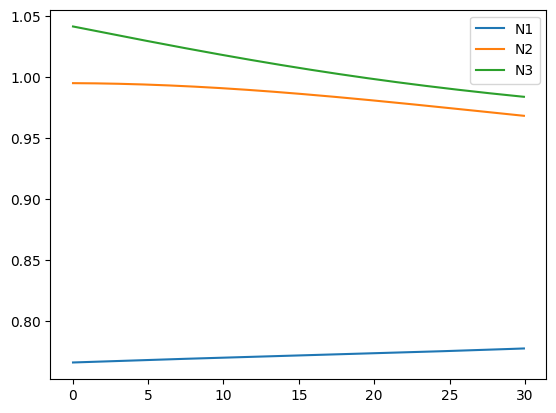

In [9]:
vectorized_u_init = vmap(lambda t: u(t, init_nn_params_list[0]), (0), 0)
vectorized_v_init = vmap(lambda t: u(t, init_nn_params_list[1]), (0), 0)
vectorized_w_init = vmap(lambda t: u(t, init_nn_params_list[2]), (0), 0)


plt.plot(train_data.times.sort(axis=0) * Tmax, vectorized_u_init(train_data.times.sort(axis=0)), label="N1")
plt.plot(train_data.times.sort(axis=0) * Tmax, vectorized_v_init(train_data.times.sort(axis=0)), label="N2")
plt.plot(train_data.times.sort(axis=0) * Tmax, vectorized_w_init(train_data.times.sort(axis=0)), label="N3")

plt.legend()

## Model parameters

In [10]:
# initial conditions for each species
N_0 = jnp.array([10., 7., 4.])
# growth rates for each species
growth_rates = jnp.array([0.1, 0.5, 0.8])
# carrying capacity for each species
carrying_capacities = jnp.array([0.04, 0.02, 0.02])
# interactions
# NOTE that for the interaction between the species **with itself** is always at position 0
# NOTE minus sign 
interactions = -jnp.array([[0, 0.001, 0.001], [0, 0.001, 0.001], [0, 0.001, 0.001]])

## Loss construction

A set of parameters as required by the losses' `evaluate` functions is a dictionary with the neural network parameters `nn_params` and the equation parameters `eq_params`. Here we construct this dictionary.

__Note__ that `nn_params` and `eq_params` must always be top level keys but can be nested dictionaries.

__Note__ that the keys of the sub dictionaries `nn_params` and `eq_params` (here `str(i)`) can differ !

In [11]:
# initiate parameters dictionary
init_params = {}

init_params["nn_params"] = {
    str(i): init_nn_params_list[i]
    for i in range(3)
}

init_params["eq_params"] = {
    str(i):{
        "carrying_capacity": carrying_capacities[i],
        "growth_rate": growth_rates[i],
        "interactions": interactions[i, :]
    }
    for i in range(3)
}

We construct a SystemLossODE with GeneralizedLotkaVolterra losses for each population. Here `key_main` refer to the key in `params["nn_params"]` which are the parameters for the main PINN of the equation (the PINN which represents the solution differentiated with respect to the `t`). `key_others` refer to the keys in `params["nn_params"]` which are the parameters for the PINNs which interact with `key_main`.

In [12]:
N1_dynamic_loss = jinns.loss.GeneralizedLotkaVolterra(key_main="0", keys_other=["1", "2"], Tmax=Tmax)
N2_dynamic_loss = jinns.loss.GeneralizedLotkaVolterra(key_main="1", keys_other=["0", "2"], Tmax=Tmax)
N3_dynamic_loss = jinns.loss.GeneralizedLotkaVolterra(key_main="2", keys_other=["0", "1"], Tmax=Tmax)

In [13]:
loss_weights = {"dyn_loss":1, "initial_condition":1 * Tmax}

loss = jinns.loss.SystemLossODE(
    u_dict={"0":u, "1":u, "2":u},
    loss_weights=loss_weights,
    dynamic_loss_dict={"0": N1_dynamic_loss, "1":N2_dynamic_loss, "2":N3_dynamic_loss},
    initial_condition_dict={"0":(float(tmin), N_0[0]), "1":(float(tmin), N_0[1]), "2":(float(tmin), N_0[2])}
)

In [14]:
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
losses, grads = losses_and_grad(
    init_params,
    train_data.get_batch()
)
l_tot, d = losses
print(f"total loss: {l_tot}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")

total loss: 4579.1962890625
Individual losses: {'dyn_loss': '676.71', 'initial_condition': '3902.49', 'observations': '0.00'}


## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [15]:
params = init_params

In [16]:
# Optimizer
import optax
tx = optax.adam(learning_rate=1e-3)

In [17]:
n_iter = int(50000)

In [18]:
key, subkey = random.split(key)

In [19]:
params, total_loss_list, loss_by_term_dict, data, loss, _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter
)

Iteration 0: loss value = 4555.5380859375


  0%|          | 0/50000 [00:00<?, ?it/s]

Iteration 1000: loss value = 318.8741149902344
Iteration 2000: loss value = 224.96556091308594
Iteration 3000: loss value = 150.76829528808594
Iteration 4000: loss value = 91.44490051269531
Iteration 5000: loss value = 56.90504455566406
Iteration 6000: loss value = 35.36555099487305
Iteration 7000: loss value = 23.368562698364258
Iteration 8000: loss value = 15.524669647216797
Iteration 9000: loss value = 10.52753734588623
Iteration 10000: loss value = 7.434139251708984
Iteration 11000: loss value = 5.210718154907227
Iteration 12000: loss value = 3.7904136180877686
Iteration 13000: loss value = 2.4596922397613525
Iteration 14000: loss value = 1.9706025123596191
Iteration 15000: loss value = 1.482211709022522
Iteration 16000: loss value = 0.9678654670715332
Iteration 17000: loss value = 1.0758025646209717
Iteration 18000: loss value = 0.4116891026496887
Iteration 19000: loss value = 0.32329803705215454
Iteration 20000: loss value = 0.5885492563247681
Iteration 21000: loss value = 0.3135

In [20]:
total_loss_list[-1]

Array(0.09908342, dtype=float32)

## Results

Plot the loss values

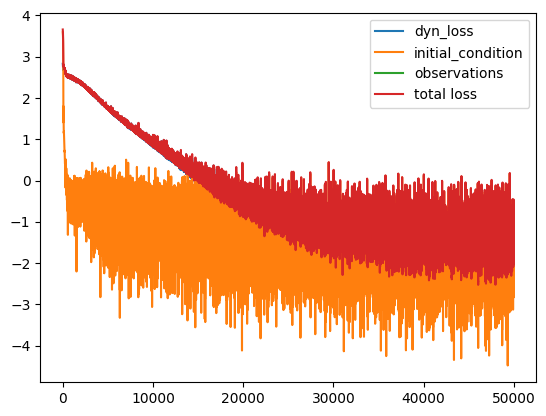

In [21]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

Plot the ODE solutions learned by the PINN

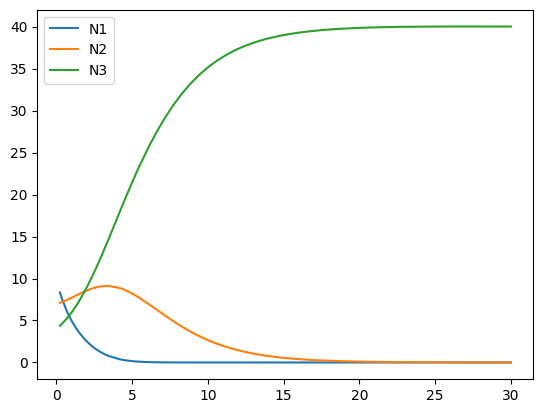

In [22]:
u_est_fp = vmap(lambda t:u(t, params["nn_params"]["0"]), (0), 0)
v_est_fp = vmap(lambda t:u(t, params["nn_params"]["1"]), (0), 0)
w_est_fp = vmap(lambda t:u(t, params["nn_params"]["2"]), (0), 0)


key, subkey = random.split(key, 2)
val_data = jinns.data.DataGeneratorODE(subkey, n, tmin, tmax, batch_size, method)

plt.plot(val_data.times.sort(axis=0) * Tmax, u_est_fp(val_data.times.sort(axis=0)), label="N1")
plt.plot(val_data.times.sort(axis=0) * Tmax, v_est_fp(val_data.times.sort(axis=0)), label="N2")
plt.plot(val_data.times.sort(axis=0) * Tmax, w_est_fp(val_data.times.sort(axis=0)), label="N3")

plt.legend()

## Compare with the scipy solver
Code from Lorenzo Sala

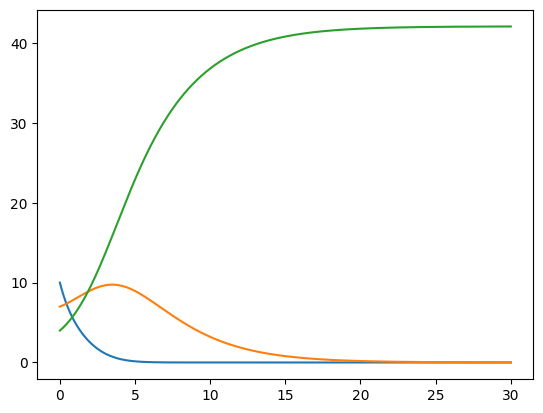

In [23]:
import numpy as np
from scipy.integrate import odeint

def lotka_volterra_log(y_log, t, params):
    """
    Generalized Lotka-Volterra model for N bacterial species, with logarithmic transformation for stability.
    
    Parameters:
        y_log (array): Array of log-transformed bacterial populations.
        t (float): Time.
        params (tuple): Tuple of model parameters.
        
    Returns:
        dydt (array): Array of derivative of log-transformed bacterial populations with respect to time.
    """
    alpha, beta, gamma, _ = params
    N = len(y_log)
    y = np.exp(y_log)
    dydt = np.zeros(N)
    
    for i in range(N):
        dydt[i] = y[i] * (alpha[i] - beta[i] * np.sum(y) - np.sum([gamma[j][i] * y[j] for j in range(N)]))
    
    dydt_log = dydt / y
    
    return dydt_log

# Define name bacteria
names = ['N1', 'N2', 'N3']
N = len(names)

# Define model parameters
death_rates = None
params = (growth_rates, carrying_capacities, interactions, death_rates)

# Define initial bacterial populations
y0 = [10, 7, 4] #[0.26, 0.37, 0.57] #

# Define time points
Tmax = 30
t = np.linspace(0, Tmax, 1000)

############################

y0_log = np.log(y0)
y_log = odeint(lotka_volterra_log, y0_log, t, args=(params,))
y = np.exp(y_log)

for i in range(N): 
    plt.plot(t, y[:,i], label=names[i])